In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset

# modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

# api
import json
import requests

In [132]:
#functions:

def i_n(series):
    i = 0
    dftest = adfuller(np.diff(series,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(series,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

# Plant 1 gen & weather data

In [133]:
p1_gen = pd.read_csv('../../data/p1_gen_dtindex.csv', index_col=0, parse_dates=True)
p1_gen.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [205]:
# let's go ahead and import the temp sensor

p1_wthr = pd.read_csv('../../data/Plant_1_Weather_Sensor_Data.csv', index_col=0, parse_dates=True)
p1_wthr.head()

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


---

# 5 days + weather data

- forecasting daily yield
- 6/13 onwards
- 4 days train
- 1 day test
- 2 day forward forecast

In [173]:
# gen data

pred_6_13 = p1_gen.copy()
pred_6_13 = pred_6_13[pred_6_13.index >= '2020-06-13 00:00:00'][['DAILY_YIELD']]
pred_6_13 = pred_6_13.groupby('DATE_TIME').sum()
pred_6_13

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


In [174]:
# wthr data

pred_wthr = p1_wthr.copy()
pred_wthr = pred_wthr[pred_wthr.index >= '2020-06-13 00:00:00']
pred_wthr

# looks like there are 2 extra rows here, compared to the gen data
# checking rows per day

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-13 00:00:00,4135001,HmiyD2TTLFNqkNe,21.771613,19.357530,0.0
2020-06-13 00:15:00,4135001,HmiyD2TTLFNqkNe,21.730046,19.504081,0.0
2020-06-13 00:30:00,4135001,HmiyD2TTLFNqkNe,21.687068,19.562803,0.0
2020-06-13 00:45:00,4135001,HmiyD2TTLFNqkNe,21.619232,19.559182,0.0
2020-06-13 01:00:00,4135001,HmiyD2TTLFNqkNe,21.625968,19.787058,0.0
...,...,...,...,...,...
2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0


## MISSING ROWS IN GEN/WTHR DATA

In [175]:
# rows per day for both gen and wthr

print(len(pred_6_13[pred_6_13.index.day == 13]) ,len(pred_wthr[pred_wthr.index.day == 13]))
print(len(pred_6_13[pred_6_13.index.day == 14]) ,len(pred_wthr[pred_wthr.index.day == 14]))
print(len(pred_6_13[pred_6_13.index.day == 15]) ,len(pred_wthr[pred_wthr.index.day == 15]))
print(len(pred_6_13[pred_6_13.index.day == 16]) ,len(pred_wthr[pred_wthr.index.day == 16]))
print(len(pred_6_13[pred_6_13.index.day == 17]) ,len(pred_wthr[pred_wthr.index.day == 17]))

# day 17 gen data is 2 rows short

96 96
96 96
96 96
96 96
94 96


In [176]:
pred_6_13[pred_6_13.index.day == 17]

,DAILY_YIELD
DATE_TIME,
2020-06-17 00:00:00,6955.232143
2020-06-17 00:15:00,0.000000
2020-06-17 00:30:00,0.000000
2020-06-17 00:45:00,0.000000
2020-06-17 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


In [177]:
pred_wthr[pred_wthr.index.day == 17]

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-17 00:00:00,4135001,HmiyD2TTLFNqkNe,22.895672,21.465773,0.0
2020-06-17 00:15:00,4135001,HmiyD2TTLFNqkNe,22.868416,21.381974,0.0
2020-06-17 00:30:00,4135001,HmiyD2TTLFNqkNe,22.826764,21.210284,0.0
2020-06-17 00:45:00,4135001,HmiyD2TTLFNqkNe,22.795615,21.357155,0.0
2020-06-17 01:00:00,4135001,HmiyD2TTLFNqkNe,22.771452,21.472048,0.0
...,...,...,...,...,...
2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0


In [178]:
# rows in wthr data, that aren't in gen data, from 6/17

df_missing_rows = pd.merge(pred_wthr, pred_6_13, left_index=True, right_index=True, how='outer', suffixes=('','_y'), indicator=True)
rows_in_df1_not_in_df2 = df_missing_rows[df_missing_rows['_merge']=='left_only'][pred_wthr.columns]

rows_in_df1_not_in_df2

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-17 06:15:00,4135001,HmiyD2TTLFNqkNe,22.093398,20.822978,0.019175
2020-06-17 06:30:00,4135001,HmiyD2TTLFNqkNe,22.275627,21.973568,0.034624


In [179]:
# checking gen data for missing indexes

pred_6_13[(pred_6_13.index == '2020-06-17 06:15:00') | (pred_6_13.index == '2020-06-17 06:30:00')]

,DAILY_YIELD
DATE_TIME,


In [180]:
# double checking gen data indexes from 6/17, between 6-7a 

pred_6_13[(pred_6_13.index >= '2020-06-17 06:00:00') & (pred_6_13.index <= '2020-06-17 07:00:00')]

# looks like it's just missing. the daily yield here was most likely 0 for both time stamps

,DAILY_YIELD
DATE_TIME,
2020-06-17 06:00:00,0.000000
2020-06-17 06:45:00,0.500000
2020-06-17 07:00:00,362.660714


#### ADDING THE MISSING ROWS

In [181]:
# adding row with index 2020-06-17 06:15:00, with col val, to end of df
pred_6_13.loc[pd.to_datetime('2020-06-17 06:15:00')] = 0

# sorting df by index and setting in place
pred_6_13.sort_index(inplace=True)

# confirming row was inserted correctly
pred_6_13[(pred_6_13.index >= '2020-06-17 06:00:00') & (pred_6_13.index <= '2020-06-17 07:00:00')]

,DAILY_YIELD
DATE_TIME,
2020-06-17 06:00:00,0.000000
2020-06-17 06:15:00,0.000000
2020-06-17 06:45:00,0.500000
2020-06-17 07:00:00,362.660714


In [182]:
# adding row with index 2020-06-17 06:30:00, with col val, to end of df
pred_6_13.loc[pd.to_datetime('2020-06-17 06:30:00')] = 0

# sorting df by index and setting in place
pred_6_13.sort_index(inplace=True)

# confirming row was inserted correctly
pred_6_13[(pred_6_13.index >= '2020-06-17 06:00:00') & (pred_6_13.index <= '2020-06-17 07:00:00')]

,DAILY_YIELD
DATE_TIME,
2020-06-17 06:00:00,0.000000
2020-06-17 06:15:00,0.000000
2020-06-17 06:30:00,0.000000
2020-06-17 06:45:00,0.500000
2020-06-17 07:00:00,362.660714


### MERGING GEN & WTHR DATA

In [183]:
# so we'll merge on the gen data, using all 3: ambient & module temp, & irradiation

pred_6_13 = pred_6_13.merge(pred_wthr[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']], 
                left_index=True, right_index=True)
pred_6_13

,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,
2020-06-13 00:00:00,5683.214286,21.771613,19.357530,0.0
2020-06-13 00:15:00,0.000000,21.730046,19.504081,0.0
2020-06-13 00:30:00,0.000000,21.687068,19.562803,0.0
2020-06-13 00:45:00,0.000000,21.619232,19.559182,0.0
2020-06-13 01:00:00,0.000000,21.625968,19.787058,0.0
...,...,...,...,...
2020-06-17 22:45:00,129571.000000,22.150570,21.480377,0.0
2020-06-17 23:00:00,129571.000000,22.129816,21.389024,0.0
2020-06-17 23:15:00,129571.000000,22.008275,20.709211,0.0


---

## PLOTTING 

- work in progress, do after SARIMAX FSM

See 'plotting gen + wthr' pointer in cappy notes for what to do in this section

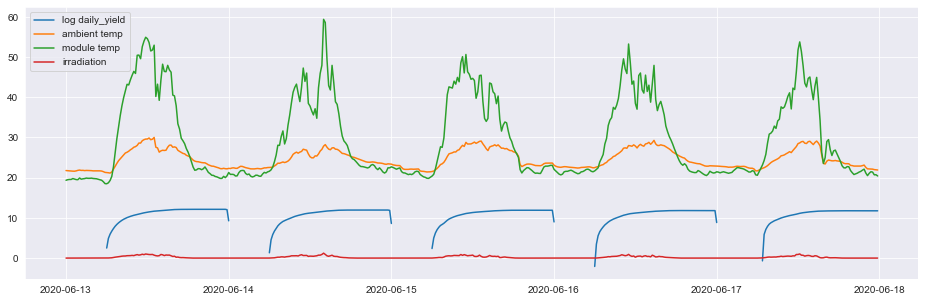

In [50]:
plt.figure(figsize=(16,5))
plt.plot(np.log(pred_6_13.DAILY_YIELD), label='log daily_yield')
plt.plot(pred_6_13.AMBIENT_TEMPERATURE, label='ambient temp')
plt.plot(pred_6_13.MODULE_TEMPERATURE, label='module temp')
plt.plot(pred_6_13.IRRADIATION, label='irradiation')
plt.legend(loc='upper left')

---

## TRAIN/TEST SPLIT

In [184]:
eotri = round(pred_6_13.shape[0] * .8)
train_pred_6_13 = pred_6_13[:eotri]
test_pred_6_13 = pred_6_13[eotri:]
print(train_pred_6_13.shape, test_pred_6_13.shape)

(384, 4) (96, 4)


In [185]:
train_pred_6_13

,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,
2020-06-13 00:00:00,5683.214286,21.771613,19.357530,0.0
2020-06-13 00:15:00,0.000000,21.730046,19.504081,0.0
2020-06-13 00:30:00,0.000000,21.687068,19.562803,0.0
2020-06-13 00:45:00,0.000000,21.619232,19.559182,0.0
2020-06-13 01:00:00,0.000000,21.625968,19.787058,0.0
...,...,...,...,...
2020-06-16 22:45:00,136429.000000,22.872359,20.925112,0.0
2020-06-16 23:00:00,136429.000000,22.962205,21.606494,0.0
2020-06-16 23:15:00,136429.000000,22.947974,21.326250,0.0


In [186]:
test_pred_6_13

,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,
2020-06-17 00:00:00,6955.232143,22.895672,21.465773,0.0
2020-06-17 00:15:00,0.000000,22.868416,21.381974,0.0
2020-06-17 00:30:00,0.000000,22.826764,21.210284,0.0
2020-06-17 00:45:00,0.000000,22.795615,21.357155,0.0
2020-06-17 01:00:00,0.000000,22.771452,21.472048,0.0
...,...,...,...,...
2020-06-17 22:45:00,129571.000000,22.150570,21.480377,0.0
2020-06-17 23:00:00,129571.000000,22.129816,21.389024,0.0
2020-06-17 23:15:00,129571.000000,22.008275,20.709211,0.0


---

## MODELING

exogenous = amb temp

In [187]:
exog_cols = ['AMBIENT_TEMPERATURE']
p,d,q = [1,1,0]
P,D,Q,s = [1,1,1,96]

pred_model = SARIMAX(endog=train_pred_6_13.iloc[:,0],
                    exog=train_pred_6_13.loc[:,exog_cols],
                    order=(p,d,q),
                    seasonal_order=(P,D,Q,s),
                    freq='15min'
                    ).fit()

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [73]:
SARIMAX?

Init signature:
SARIMAX(
    endog,
    exog=None,
    order=(1, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    trend=None,
    measurement_error=False,
    time_varying_regression=False,
    mle_regression=True,
    simple_differencing=False,
    enforce_stationarity=True,
    enforce_invertibility=True,
    hamilton_representation=False,
    concentrate_scale=False,
    trend_offset=1,
    use_exact_diffuse=False,
    dates=None,
    freq=None,
    missing='none',
    **kwargs,
)
Docstring:     
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
model

Parameters
----------
endog : array_like
    The observed time-series process :math:`y`
exog : array_like, optional
    Array of exogenous regressors, shaped nobs x k.
order : iterable or iterable of iterables, optional
    The (p,d,q) order of the model for the number of AR parameters,
    differences, and MA parameters. `d` must be an integer
    indicating the integration order of the process, while
    `p` and

#### TRAIN PREDICTION

In [188]:
train_pred_yhat = pred_model.predict(typ='levels') # returns predictions at the level of the og data (takes out differencing or i)

In [189]:
train_pred_yhat = pd.DataFrame(train_pred_yhat)
train_pred_yhat.columns = ['pred_train_daily_yld']
train_pred_yhat[train_pred_yhat.pred_train_daily_yld < 0] = 0
train_pred_yhat['actual_train_daily_yld'] = train_pred_6_13.DAILY_YIELD
train_pred_yhat

,pred_train_daily_yld,actual_train_daily_yld
2020-06-13 00:00:00,20449.352519,5683.214286
2020-06-13 00:15:00,5291.924798,0.000000
2020-06-13 00:30:00,0.000000,0.000000
2020-06-13 00:45:00,0.000000,0.000000
2020-06-13 01:00:00,8.365063,0.000000
...,...,...
2020-06-16 22:45:00,136383.276207,136429.000000
2020-06-16 23:00:00,136539.205306,136429.000000
2020-06-16 23:15:00,136424.415329,136429.000000
2020-06-16 23:30:00,136376.511155,136429.000000


In [192]:
print('SARIMAX train R2 Score: %f' % (r2_score(train_pred_yhat.actual_train_daily_yld,
                                               train_pred_yhat.pred_train_daily_yld)))
print('-'*15)

print('SARIMAX train MAE Score: %f' % (mean_absolute_error(train_pred_yhat.actual_train_daily_yld,
                                                           train_pred_yhat.pred_train_daily_yld)))
print('-'*15)

print('SARIMAX train RMSE Score: %f' % (mean_squared_error(train_pred_yhat.actual_train_daily_yld,
                                                           train_pred_yhat.pred_train_daily_yld,
                                                           squared=False)))

SARIMAX train R2 Score: 0.986672
---------------
SARIMAX train MAE Score: 1244.521928
---------------
SARIMAX train RMSE Score: 7899.642004


#### TEST PREDICTION

In [191]:
test_pred_yhat = pred_model.predict(start=test_pred_6_13.index[0], 
                                    end=test_pred_6_13.index[-1], 
                                    exog=test_pred_6_13.loc[:,exog_cols], 
                                    typ='levels')

In [193]:
test_pred_yhat = pd.DataFrame(test_pred_yhat)
test_pred_yhat.columns = ['pred_test_daily_yld']
test_pred_yhat[test_pred_yhat.pred_test_daily_yld < 0] = 0
test_pred_yhat['actual_test_daily_yld'] = test_pred_6_13.DAILY_YIELD
test_pred_yhat

,pred_test_daily_yld,actual_test_daily_yld
2020-06-17 00:00:00,0.000000,6955.232143
2020-06-17 00:15:00,0.000000,0.000000
2020-06-17 00:30:00,0.000000,0.000000
2020-06-17 00:45:00,0.000000,0.000000
2020-06-17 01:00:00,0.000000,0.000000
...,...,...
2020-06-17 22:45:00,127457.148098,129571.000000
2020-06-17 23:00:00,127377.726225,129571.000000
2020-06-17 23:15:00,127277.669125,129571.000000
2020-06-17 23:30:00,127250.540191,129571.000000


In [305]:
print('SARIMAX test R2 Score: %f' % (r2_score(test_pred_yhat.actual_test_daily_yld,
                                              test_pred_yhat.pred_test_daily_yld)))
print('-'*15)

print('SARIMAX test MAE Score: %f' % (mean_absolute_error(test_pred_yhat.actual_test_daily_yld,
                                                          test_pred_yhat.pred_test_daily_yld)))
print('-'*15)

print('SARIMAX test RMSE Score: %f' % (mean_squared_error(test_pred_yhat.actual_test_daily_yld,
                                                          test_pred_yhat.pred_test_daily_yld,
                                                          squared=False)))

SARIMAX test R2 Score: 0.993385
---------------
SARIMAX test MAE Score: 3282.352677
---------------
SARIMAX test RMSE Score: 4629.702597


#### PLOTTING TRAIN/TEST ACTUAL VS PREDICTION

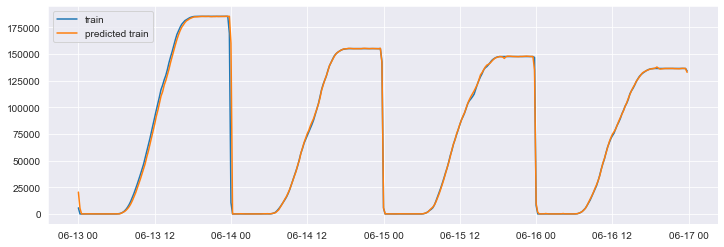

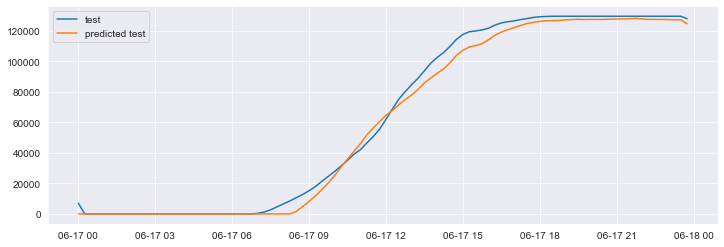

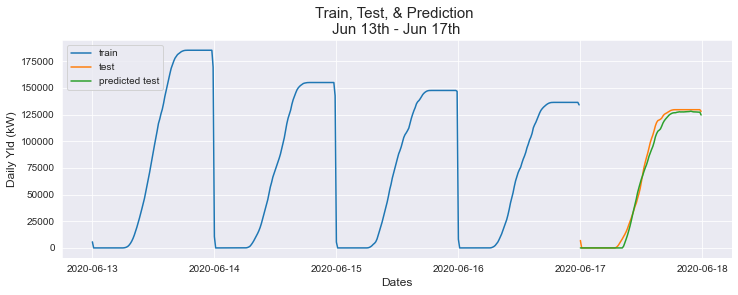

In [207]:
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(train_pred_yhat.actual_train_daily_yld, label='train')
ax1.plot(train_pred_yhat.pred_train_daily_yld, label='predicted train')
ax1.legend(loc='upper left')

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(test_pred_yhat.actual_test_daily_yld, label='test')
ax2.plot(test_pred_yhat.pred_test_daily_yld, label='predicted test')
ax2.legend(loc='upper left')

fig, ax3 = plt.subplots(figsize=(12,4))
ax3.plot(train_pred_yhat.actual_train_daily_yld, label='train')
ax3.plot(test_pred_yhat.actual_test_daily_yld, label='test')
ax3.plot(test_pred_yhat.pred_test_daily_yld, label='predicted test')
ax3.set_title('Train, Test, & Prediction \n Jun 13th - Jun 17th ', size=15)
ax3.set_ylabel('Daily Yld (kW)', size=12)
ax3.set_xlabel('Dates', size=12)

ax3.legend(loc='upper left');

#### FORECASTING

In [210]:
resp = requests.get('https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?aggregateHours=0&aggregateMinutes=15&combinationMethod=aggregate&startDateTime=2020-06-17T00%3A00%3A00&endDateTime=2020-06-22T00%3A00%3A00&maxStations=-1&maxDistance=-1&contentType=json&unitGroup=metric&locationMode=array&key=W9LFIRDB34JXS3E2KUHGX3RD9&dataElements=default&locations=Nashik%2C%20India')

In [211]:
resp.status_code == requests.codes.ok

True

In [214]:
resp.__dict__

{'_content': b'{"columns":{"temp":{"id":"temp","name":"Temperature","type":2,"unit":"degC"},"maxt":{"id":"maxt","name":"Maximum Temperature","type":2,"unit":"degC"},"visibility":{"id":"visibility","name":"Visibility","type":2,"unit":"km"},"wspd":{"id":"wspd","name":"Wind Speed","type":2,"unit":"kph"},"heatindex":{"id":"heatindex","name":"Heat Index","type":2,"unit":"degC"},"cloudcover":{"id":"cloudcover","name":"Cloud Cover","type":2,"unit":"%"},"mint":{"id":"mint","name":"Minimum Temperature","type":2,"unit":"degC"},"datetime":{"id":"datetime","name":"Date time","type":3,"unit":null},"precip":{"id":"precip","name":"Precipitation","type":2,"unit":"mm"},"weathertype":{"id":"weathertype","name":"Weather Type","type":1,"unit":null},"snowdepth":{"id":"snowdepth","name":"Snow Depth","type":2,"unit":"cm"},"name":{"id":"name","name":"Name","type":1,"unit":null},"humidity":{"id":"humidity","name":"Relative Humidity","type":2,"unit":"%"},"wgust":{"id":"wgust","name":"Wind Gust","type":2,"unit":

In [215]:
type(resp)

requests.models.Response

In [229]:
type(resp.json())

dict

In [231]:
j

{'columns': {'temp': {'id': 'temp',
   'name': 'Temperature',
   'type': 2,
   'unit': 'degC'},
  'maxt': {'id': 'maxt',
   'name': 'Maximum Temperature',
   'type': 2,
   'unit': 'degC'},
  'visibility': {'id': 'visibility',
   'name': 'Visibility',
   'type': 2,
   'unit': 'km'},
  'wspd': {'id': 'wspd', 'name': 'Wind Speed', 'type': 2, 'unit': 'kph'},
  'heatindex': {'id': 'heatindex',
   'name': 'Heat Index',
   'type': 2,
   'unit': 'degC'},
  'cloudcover': {'id': 'cloudcover',
   'name': 'Cloud Cover',
   'type': 2,
   'unit': '%'},
  'mint': {'id': 'mint',
   'name': 'Minimum Temperature',
   'type': 2,
   'unit': 'degC'},
  'datetime': {'id': 'datetime', 'name': 'Date time', 'type': 3, 'unit': None},
  'precip': {'id': 'precip', 'name': 'Precipitation', 'type': 2, 'unit': 'mm'},
  'weathertype': {'id': 'weathertype',
   'name': 'Weather Type',
   'type': 1,
   'unit': None},
  'snowdepth': {'id': 'snowdepth',
   'name': 'Snow Depth',
   'type': 2,
   'unit': 'cm'},
  'name': {'

In [260]:
j = resp.json()

forecast_wthr_data_all = pd.DataFrame.from_dict(j['locations'][0]['values'])
forecast_wthr_data_all

,temp,maxt,visibility,wspd,datetimeStr,heatindex,cloudcover,mint,datetime,precip,weathertype,snowdepth,humidity,wgust,conditions,windchill
0,NaN,NaN,NaN,NaN,2020-06-17T00:00:00+05:30,NaN,NaN,NaN,1592352000000,0.0,None,None,NaN,None,,None
1,NaN,NaN,NaN,NaN,2020-06-17T00:15:00+05:30,NaN,NaN,NaN,1592352900000,0.0,None,None,NaN,None,,None
2,NaN,NaN,NaN,NaN,2020-06-17T00:30:00+05:30,NaN,NaN,NaN,1592353800000,0.0,None,None,NaN,None,,None
3,NaN,NaN,NaN,NaN,2020-06-17T00:45:00+05:30,NaN,NaN,NaN,1592354700000,0.0,None,None,NaN,None,,None
4,NaN,NaN,NaN,NaN,2020-06-17T01:00:00+05:30,NaN,NaN,NaN,1592355600000,0.0,None,None,NaN,None,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,NaN,NaN,NaN,NaN,2020-06-21T22:15:00+05:30,NaN,NaN,NaN,1592777700000,0.0,None,None,NaN,None,,None
474,NaN,NaN,NaN,NaN,2020-06-21T22:30:00+05:30,NaN,NaN,NaN,1592778600000,0.0,None,None,NaN,None,,None
475,NaN,NaN,NaN,NaN,2020-06-21T22:45:00+05:30,NaN,NaN,NaN,1592779500000,0.0,None,None,NaN,None,,None
476,NaN,NaN,NaN,NaN,2020-06-21T23:00:00+05:30,NaN,NaN,NaN,1592780400000,0.0,None,None,NaN,None,,None


In [261]:
# removing '+05:30' from the string date time column

forecast_wthr_data_all.datetimeStr = forecast_wthr_data_all.datetimeStr.map(lambda x: x[:-6])
forecast_wthr_data_all

,temp,maxt,visibility,wspd,datetimeStr,heatindex,cloudcover,mint,datetime,precip,weathertype,snowdepth,humidity,wgust,conditions,windchill
0,NaN,NaN,NaN,NaN,2020-06-17T00:00:00,NaN,NaN,NaN,1592352000000,0.0,None,None,NaN,None,,None
1,NaN,NaN,NaN,NaN,2020-06-17T00:15:00,NaN,NaN,NaN,1592352900000,0.0,None,None,NaN,None,,None
2,NaN,NaN,NaN,NaN,2020-06-17T00:30:00,NaN,NaN,NaN,1592353800000,0.0,None,None,NaN,None,,None
3,NaN,NaN,NaN,NaN,2020-06-17T00:45:00,NaN,NaN,NaN,1592354700000,0.0,None,None,NaN,None,,None
4,NaN,NaN,NaN,NaN,2020-06-17T01:00:00,NaN,NaN,NaN,1592355600000,0.0,None,None,NaN,None,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,NaN,NaN,NaN,NaN,2020-06-21T22:15:00,NaN,NaN,NaN,1592777700000,0.0,None,None,NaN,None,,None
474,NaN,NaN,NaN,NaN,2020-06-21T22:30:00,NaN,NaN,NaN,1592778600000,0.0,None,None,NaN,None,,None
475,NaN,NaN,NaN,NaN,2020-06-21T22:45:00,NaN,NaN,NaN,1592779500000,0.0,None,None,NaN,None,,None
476,NaN,NaN,NaN,NaN,2020-06-21T23:00:00,NaN,NaN,NaN,1592780400000,0.0,None,None,NaN,None,,None


In [262]:
# changing date time column to datetime object, and then setting it as index

forecast_wthr_data_all.datetimeStr = pd.to_datetime(forecast_wthr_data_all.datetimeStr, infer_datetime_format=True)
forecast_wthr_data_all.set_index('datetimeStr', inplace=True)
forecast_wthr_data_all

,temp,maxt,visibility,wspd,heatindex,cloudcover,mint,datetime,precip,weathertype,snowdepth,humidity,wgust,conditions,windchill
datetimeStr,,,,,,,,,,,,,,,
2020-06-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592352000000,0.0,None,None,NaN,None,,None
2020-06-17 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592352900000,0.0,None,None,NaN,None,,None
2020-06-17 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592353800000,0.0,None,None,NaN,None,,None
2020-06-17 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592354700000,0.0,None,None,NaN,None,,None
2020-06-17 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592355600000,0.0,None,None,NaN,None,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-21 22:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592777700000,0.0,None,None,NaN,None,,None
2020-06-21 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592778600000,0.0,None,None,NaN,None,,None
2020-06-21 22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592779500000,0.0,None,None,NaN,None,,None


In [263]:
forecast_wthr_temp = forecast_wthr_data_all[['temp']]
forecast_wthr_temp

,temp
datetimeStr,
2020-06-17 00:00:00,NaN
2020-06-17 00:15:00,NaN
2020-06-17 00:30:00,NaN
2020-06-17 00:45:00,NaN
2020-06-17 01:00:00,NaN
...,...
2020-06-21 22:15:00,NaN
2020-06-21 22:30:00,NaN
2020-06-21 22:45:00,NaN


In [266]:
forecast_wthr_temp.isna().sum()

temp    331
dtype: int64

In [268]:
# interpolate

forecast_wthr_temp.interpolate(inplace=True)
forecast_wthr_temp

<ipython-input-268-8f891af3e272>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_wthr_temp.interpolate(inplace=True)


,temp
datetimeStr,
2020-06-17 00:00:00,NaN
2020-06-17 00:15:00,NaN
2020-06-17 00:30:00,NaN
2020-06-17 00:45:00,NaN
2020-06-17 01:00:00,NaN
...,...
2020-06-21 22:15:00,24.709091
2020-06-21 22:30:00,24.581818
2020-06-21 22:45:00,24.454545


In [269]:
forecast_wthr_temp.isna().sum()

temp    9
dtype: int64

In [270]:
forecast_wthr_temp.index

DatetimeIndex(['2020-06-17 00:00:00', '2020-06-17 00:15:00',
               '2020-06-17 00:30:00', '2020-06-17 00:45:00',
               '2020-06-17 01:00:00', '2020-06-17 01:15:00',
               '2020-06-17 01:30:00', '2020-06-17 01:45:00',
               '2020-06-17 02:00:00', '2020-06-17 02:15:00',
               ...
               '2020-06-21 21:00:00', '2020-06-21 21:15:00',
               '2020-06-21 21:30:00', '2020-06-21 21:45:00',
               '2020-06-21 22:00:00', '2020-06-21 22:15:00',
               '2020-06-21 22:30:00', '2020-06-21 22:45:00',
               '2020-06-21 23:00:00', '2020-06-21 23:15:00'],
              dtype='datetime64[ns]', name='datetimeStr', length=478, freq=None)

In [271]:
forecast_wthr_temp = forecast_wthr_temp[(forecast_wthr_temp.index >= '2020-06-17 23:45:00') & (forecast_wthr_temp.index <= '2020-06-20 00:00:00')]
forecast_wthr_temp

,temp
datetimeStr,
2020-06-17 23:45:00,24.654545
2020-06-18 00:00:00,24.609091
2020-06-18 00:15:00,24.563636
2020-06-18 00:30:00,24.518182
2020-06-18 00:45:00,24.472727
...,...
2020-06-19 23:00:00,25.645455
2020-06-19 23:15:00,25.600000
2020-06-19 23:30:00,25.600000


In [286]:
forecast_model = SARIMAX(endog=pred_6_13.iloc[:,0],
                         exog=pred_6_13.loc[:,exog_cols],
                         order=(p,d,q),
                         seasonal_order=(P,D,Q,s),
                         freq='15min').fit()

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [296]:
forecast = forecast_model.forecast(steps = 194, 
                                   exog=forecast_wthr_temp.loc[:,['temp']], 
                                   return_conf_int=True)

In [297]:
forecast

2020-06-18 00:00:00      2948.539702
2020-06-18 00:15:00     -4055.476201
2020-06-18 00:30:00     -4046.689979
2020-06-18 00:45:00     -4054.780927
2020-06-18 01:00:00     -4074.874636
                           ...      
2020-06-19 23:15:00    126176.240923
2020-06-19 23:30:00    126163.220498
2020-06-19 23:45:00    123958.275599
2020-06-20 00:00:00     -4444.388685
2020-06-20 00:15:00    -11463.096709
Freq: 15T, Length: 194, dtype: float64

In [298]:
forecast[forecast < 0]= 0
forecast

2020-06-18 00:00:00      2948.539702
2020-06-18 00:15:00         0.000000
2020-06-18 00:30:00         0.000000
2020-06-18 00:45:00         0.000000
2020-06-18 01:00:00         0.000000
                           ...      
2020-06-19 23:15:00    126176.240923
2020-06-19 23:30:00    126163.220498
2020-06-19 23:45:00    123958.275599
2020-06-20 00:00:00         0.000000
2020-06-20 00:15:00         0.000000
Freq: 15T, Length: 194, dtype: float64

In [282]:
# the get_forecast method? Can't get confidence intervals

forecast_get_pred_method = forecast_model.get_forecast(steps = 194, 
                                   exog=forecast_wthr_temp.loc[:,'temp'])

In [281]:
forecast_get_pred_method

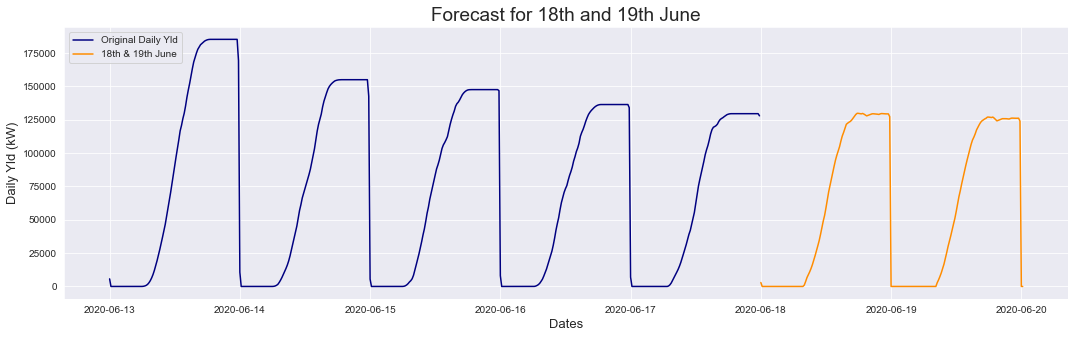

In [299]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(pred_6_13.DAILY_YIELD, label = 'Original Daily Yld', color = 'navy')
ax.plot(forecast, label='18th & 19th June', color = 'darkorange')
# ax.fill_between(f_prediction_df.index, f_prediction_df.conf_lower, f_prediction_df.conf_upper, alpha=0.2)
ax.legend(loc='upper left')
ax.set_title('Forecast for 18th and 19th June', size=19)
ax.set_ylabel('Daily Yld (kW)', size=13)
ax.set_xlabel('Dates', size=13)
plt.show()

In [302]:
forecast[forecast.index.day == 18].max()

129850.41001668257

In [301]:
forecast[forecast.index.day == 19].max()

127018.60144740208

In [303]:
# https://www.ceew.in/blogs/urban-households-consumed-less-electricity-during-lockdown-some-parts-india

forecast[forecast.index.day == 18].max()/5.7

22780.77368713729

In [304]:
forecast[forecast.index.day == 19].max()/5.7

22283.96516621089